In [2]:
%load_ext autoreload
%autoreload 2

import os
import warnings

warnings.filterwarnings("ignore")
os.chdir("../")

In [3]:
import pandas as pd
import numpy as np

In [4]:
nft_trades = pd.read_csv("historic_data/profits.csv", low_memory=False).set_index(
    ["nft_id", "trade_no"]
)
nft_trades["holding_period"] = pd.to_timedelta(nft_trades["holding_period"]).dt.days
nft_trades["sell_date"] = pd.to_datetime(nft_trades["sell_date"])
nft_trades["purchase_date"] = pd.to_datetime(nft_trades["purchase_date"])

# Set max USD profit and max ETH profit to 100x
nft_trades_outlier_reduced = nft_trades[(nft_trades["profit_usd"] < 100) & (nft_trades["profit_eth"] < 100)]
nft_trades_100x = nft_trades[(nft_trades["profit_usd"] >= 100) & (nft_trades["profit_eth"] >= 100)]

In [5]:
df = pd.DataFrame(nft_trades["profit_usd"], index = nft_trades.index)
a = 0
for i in [0.1, 0.5, 1, 10, 100, np.inf]:
    df[str(a)+"_"+str(i)] = nft_trades[nft_trades["purchase_price_eth"].between(a,i, inclusive="left")]["profit_usd"]
    a = i
df = df.set_index("profit_usd").isna().replace({True: 0, False: 1})

In [42]:
df.head()

,0_0.1,0.1_0.5,0.5_1,1_10,10_100,100_inf
profit_usd,,,,,,
0.152352,0,0,0,1,0,0
2.147954,0,0,0,1,0,0
1.423239,0,0,0,1,0,0
-0.296476,0,0,0,0,1,0
2.730662,0,0,0,1,0,0


In [11]:
df.corr()

,0_0.1,0.1_0.5,0.5_1,1_10,10_100,100_inf
0_0.1,1.000000,-0.368094,-0.186292,-0.204045,-0.042412,-0.005261
0.1_0.5,-0.368094,1.000000,-0.435748,-0.477273,-0.099205,-0.012305
0.5_1,-0.186292,-0.435748,1.000000,-0.241547,-0.050207,-0.006228
1_10,-0.204045,-0.477273,-0.241547,1.000000,-0.054992,-0.006821
10_100,-0.042412,-0.099205,-0.050207,-0.054992,1.000000,-0.001418
100_inf,-0.005261,-0.012305,-0.006228,-0.006821,-0.001418,1.000000


In [24]:
def get_trade_count(nft_trades):
    nft_trades["trade_count"] = None
    collection_list = nft_trades["collection"].tolist()
    i = 0
    for nft in collection_list:
        nft_counter = 0
        try:
            while nft == collection_list[i]:
                nft_counter += 1
                nft_trades.loc[i, "trade_count"] = nft_counter
                i += 1
        except:
            break
    return nft_trades.set_index(["collection", "trade_count"])

In [28]:
collections = get_trade_count(nft_trades_outlier_reduced.reset_index())

In [35]:
pivot=collections[["profit_usd"]].reset_index().pivot_table(index="trade_count", columns="collection", values="profit_usd")

In [85]:
pivot

collection
0xmons.xyz           0.152352
10KTF                0.130694
3Landers            -0.956991
8SIAN                0.412796
AIMoonbirds          0.641774
                       ...   
Women and Weapons    0.509887
WonderPals          -0.145977
YOLO                -0.529444
inbetweeners        -0.021769
merge.               0.388894
Name: 1, Length: 89, dtype: float64

In [124]:
correlation_matrix = pivot.corr(method="pearson", min_periods=0).dropna(axis=1, thresh=10)

In [151]:
correlation_matrix.isna()

collection,0xmons.xyz,10KTF,3Landers,8SIAN,AIMoonbirds,AVASTAR Token,Anatomy Science Ape Club,ArtAI,Async Art,Autoglyphs,...,Tubby Cats,Voxies,Waifus,Weirdo Ghost Gang,Women Rise,Women and Weapons,WonderPals,YOLO,inbetweeners,merge.
collection,,,,,,,,,,,,,,,,,,,,,
0xmons.xyz,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10KTF,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3Landers,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8SIAN,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
AIMoonbirds,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Women and Weapons,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
WonderPals,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
YOLO,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


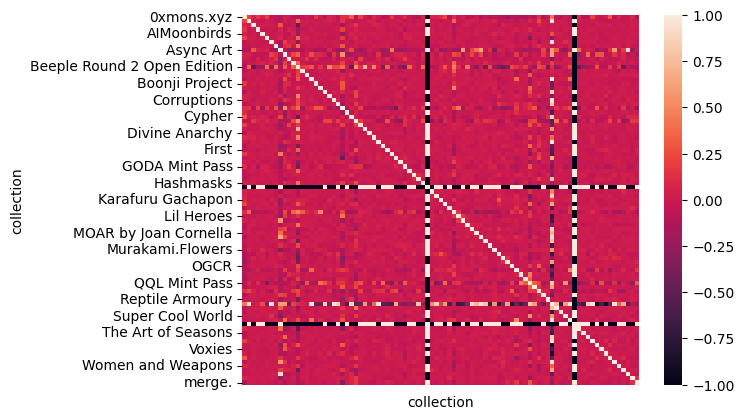

In [148]:
import seaborn as sns
import matplotlib.pyplot as plt

df = sns.load_dataset('penguins')
sns.heatmap(correlation_matrix, annot=False, xticklabels=False, vmax=1, vmin=-1)
plt.show()

In [45]:
correlation_matrix[["0xmons.xyz"]].sort_values("0xmons.xyz", ascending=False).head(15)

collection,0xmons.xyz
collection,
0xmons.xyz,1.000000
SUPERPLASTIC: SUPERGUCCI,0.418674
Cypher,0.297950
Weirdo Ghost Gang,0.290540
Killer GF,0.211231
TheCurrency,0.198112
10KTF,0.197332
AVASTAR Token,0.193201
Desperate ApeWives,0.180737


In [46]:
pivot[:1000].corr()[["0xmons.xyz"]].sort_values("0xmons.xyz", ascending=False).tail(15)

collection,0xmons.xyz
collection,
NFTBoxes,-0.109430
Squishiverse,-0.114230
Beeple Round 2 Open Edition,-0.114490
RareApepeYachtClub,-0.118576
Phanta Bear,-0.125357
Mutant Garden Seeder,-0.135531
C-01 Official Collection,-0.138057
Kitty Crypto Gang,-0.151100
merge.,-0.159221
